In [ ]:
# !pip install ultralytics --quiet
# !pip install -U ipywidgets --quiet

In [ ]:
from ultralytics import YOLO
# from ultralytics.yolov8 import YOLO

In [ ]:
# model = YOLO("saved_model_yolo.pt")
model = YOLO("best.onnx")

In [ ]:
# results = model.train(data='/kaggle/input/cardetection/data.yaml', epochs=30, imgsz=320, batch = -1, augment=True)

In [446]:
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from PIL import Image


#### Checking for same order of images and labels 

In [ ]:
# Checking all the images and labels are in the same order or not.
image_folder = r"archive\test\images"
labels_folder = r"archive\test\labels"
images_list = os.listdir(image_folder)
images_list = ["".join(i.split(".")[:-1]) for i in images_list]
labels_list = os.listdir(labels_folder)
labels_list = ["".join(i.split(".")[:-1]) for i in labels_list]
if images_list == labels_list:
    print("all the images and labels are in the same order")
else:
    print("all the images and labels are not in the same order")

In [ ]:
images_list = os.listdir(image_folder)
test_images  = []
for file_name in images_list:
    file_path = os.path.join(image_folder, file_name)
    img = Image.open(file_path)
    test_images.append(img)

In [ ]:
output_list = []
for image in test_images:
    output = model(image, imgsz=320)
    output_list.append(output)

#### Class names as dictionary

In [445]:
class_names = output[0].names
class_names

{0: 'Green Light',
 1: 'Red Light',
 2: 'Speed Limit 10',
 3: 'Speed Limit 100',
 4: 'Speed Limit 110',
 5: 'Speed Limit 120',
 6: 'Speed Limit 20',
 7: 'Speed Limit 30',
 8: 'Speed Limit 40',
 9: 'Speed Limit 50',
 10: 'Speed Limit 60',
 11: 'Speed Limit 70',
 12: 'Speed Limit 80',
 13: 'Speed Limit 90',
 14: 'Stop'}

#### Predicted Classes from Model

In [285]:
predicted_classes_float = []
for i in range(len(output_list)):
    box = output_list[i][0].boxes
    predicted_classes_float.append(list(box.cls))

In [305]:
import torch

def convert_tensor_list(tensor_list):
  converted_list = []
  for tensor in tensor_list:
    # Check if single-element tensor
    if len(tensor) == 1:
      converted_list.append([int(tensor[0].item())])
    else:
      # Convert multi-element tensor to list\
      temp = []
      for i in range (len(tensor)):
        temp.append(int(tensor[i].item()))
      converted_list.append(temp)
  return converted_list

predicted_classes = convert_tensor_list(predicted_classes_float)

In [ ]:
import matplotlib.pyplot as plt
for r in output_list:
    img = Image.fromarray(r[0].plot()[..., ::-1])
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [228]:
file_names_list = os.listdir(r"C:\Users\Vaishali Agarwal\OneDrive\Documents\CMI\Applied ML\Project\archive\test\labels")

#### True Lables from test data

In [375]:
true_labels = []
all_labels_lines = []
for file_name in file_names_list:
    with open(os.path.join(r"archive\test\labels",file_name), "r") as file:
        all_labels_lines.append(file.readlines())

true_labels = []
for i in all_labels_lines:
    temp = []
    for j in i:
        temp.append(int(j.split()[0]))
    true_labels.append(temp)


In [307]:
true_labels_mod = [tuple(i) for i in true_labels]
predicted_classes_mod = [tuple(i) for i in predicted_classes]


#### mlb to convert labels into binary matrix representation where each label is binarized into a separate binary column.

In [308]:
mlb = MultiLabelBinarizer()
actual = mlb.fit_transform(true_labels_mod)
pred = mlb.fit_transform(predicted_classes_mod)


#### dictionary which will have precision, recall, f1_score and support for each label

In [413]:
scores_dict = {}
for label in class_names.keys():
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(predicted_classes)):
        if label in true_labels[i] and label in predicted_classes[i]:
            tp+=1
        elif label not in true_labels[i] and label not in predicted_classes[i]:
            tn+=1
        elif label not in true_labels[i] and label in predicted_classes[i]:
            fp+=1
        else:
            fn+=1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall / (precision+recall)
    scores_dict[label] = (round(precision,2), round(recall,2), round(f1_score,2),tp+fn)

In [414]:
confusion_df = pd.DataFrame.from_dict(scores_dict, orient='index', columns=['Precision', 'Recall', 'F1 Score', "support"])
confusion_df.rename(index=class_names, inplace=True)

Confusion Matrix DataFrame:
                 Precision  Recall  F1 Score  support
Green Light           0.92    0.79      0.85       77
Red Light             0.96    0.72      0.82       71
Speed Limit 10        1.00    1.00      1.00        2
Speed Limit 100       0.98    0.91      0.94       45
Speed Limit 110       1.00    0.76      0.86       21
Speed Limit 120       0.95    1.00      0.98       40
Speed Limit 20        0.98    0.89      0.93       46
Speed Limit 30        0.96    0.87      0.91       60
Speed Limit 40        0.98    0.98      0.98       51
Speed Limit 50        0.88    0.91      0.90       47
Speed Limit 60        0.98    0.96      0.97       45
Speed Limit 70        0.98    0.88      0.93       52
Speed Limit 80        0.94    0.97      0.95       60
Speed Limit 90        0.96    0.79      0.87       33
Stop                  1.00    1.00      1.00       50


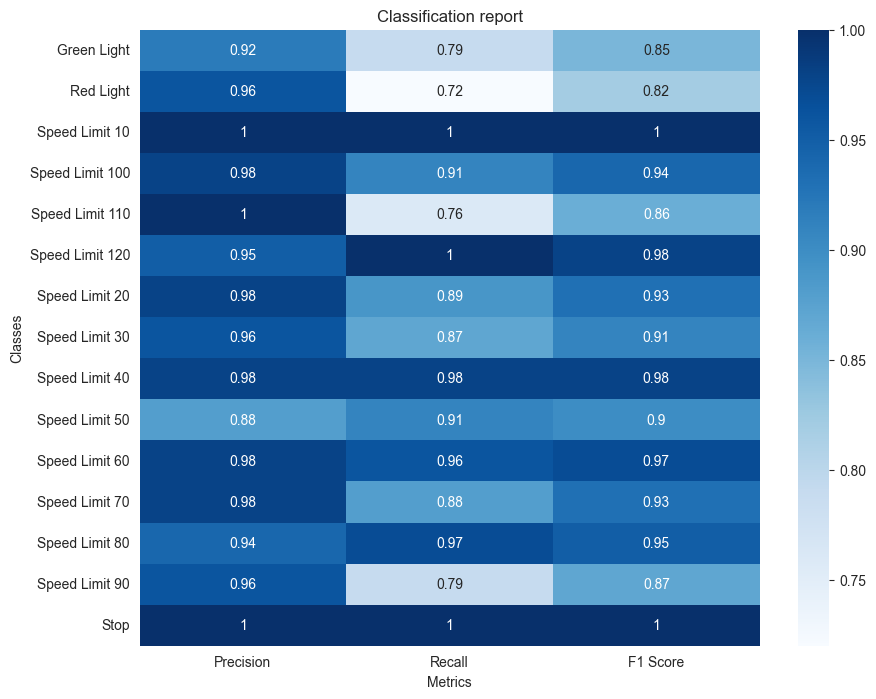

In [426]:
import seaborn as sns
# Plot heatmap
# Set seaborn style
sns.set_style("whitegrid")
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df[['Precision', 'Recall', 'F1 Score']], annot=True, cmap='Blues')
plt.title('Classification report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [440]:
macro_avg = {
    'Precision': confusion_df['Precision'].mean(),
    'Recall': confusion_df['Recall'].mean(),
    'F1 Score': confusion_df['F1 Score'].mean()
}

# Calculate weighted-average
weighted_avg = {
    'Precision': (confusion_df['Precision'] * confusion_df['support']).sum() / confusion_df['support'].sum(),
    'Recall': (confusion_df['Recall'] * confusion_df['support']).sum() / confusion_df['support'].sum(),
    'F1 Score': (confusion_df['F1 Score'] * confusion_df['support']).sum() / confusion_df['support'].sum()
}

# Create a DataFrame to display final results
final_results = pd.DataFrame({'Macro-average': macro_avg, 'Weighted-average': weighted_avg})



           Macro-average  Weighted-average
Precision       0.964667          0.958943
Recall          0.895333          0.885686
F1 Score        0.926000          0.918014


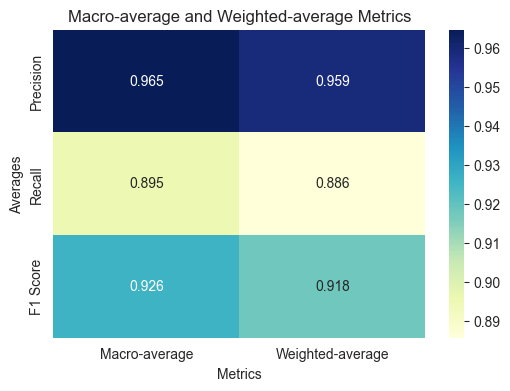

In [442]:
# Create a heatmap of the final results DataFrame
plt.figure(figsize=(6, 4))
sns.heatmap(final_results, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Macro-average and Weighted-average Metrics')
plt.xlabel('Metrics')
plt.ylabel('Averages')
plt.show()

#### Confusion Matrix for each class

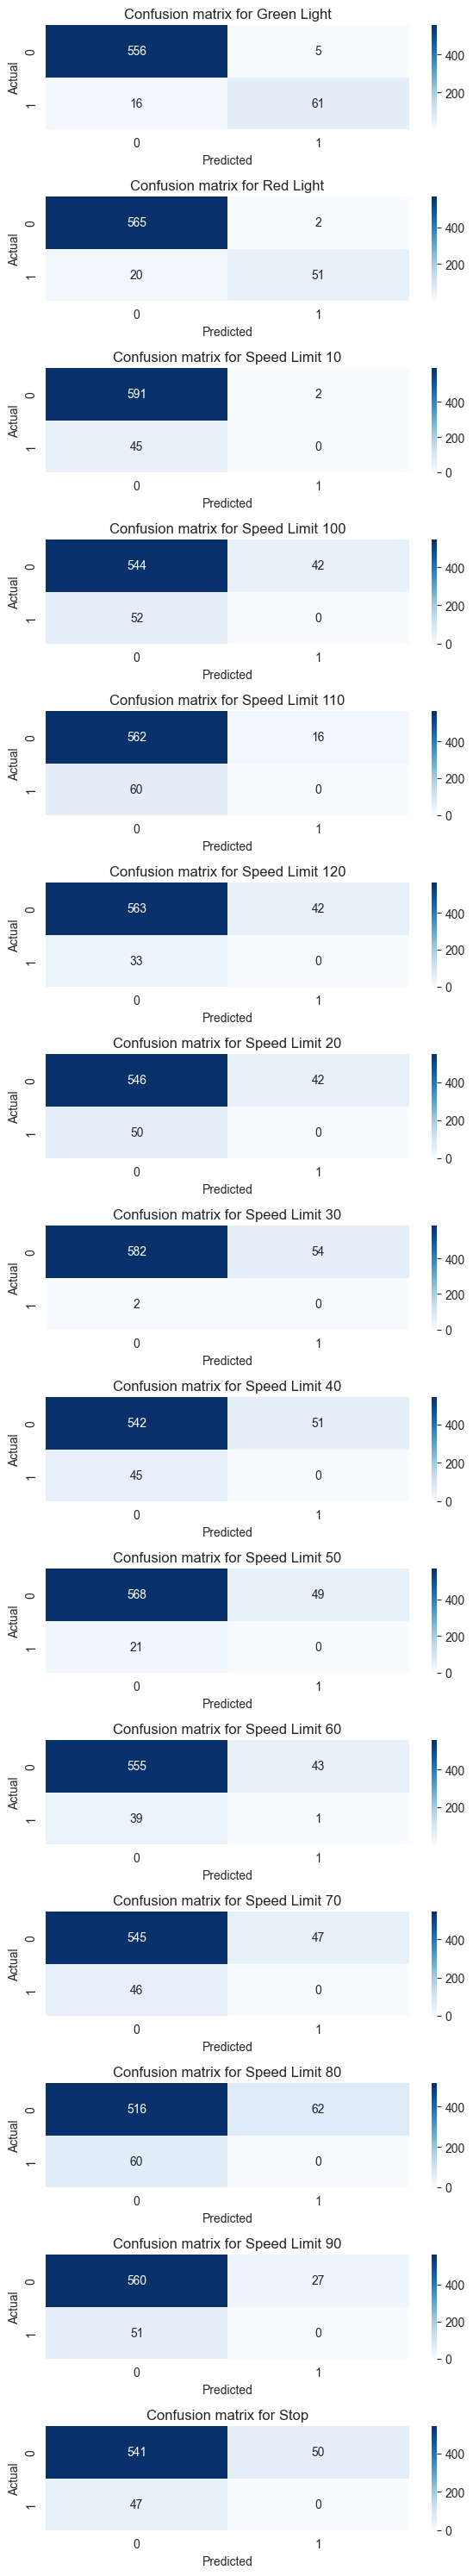

In [435]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(actual, pred)

# Set up subplots
num_classes = len(class_names)
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(6, 2*num_classes))

# Plot confusion matrix for each class
for i, (label_mcm, label) in enumerate(zip(mcm, class_names.values())):
    sns.heatmap(label_mcm, annot=True, cmap='Blues', fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion matrix for {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()
